In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.util import crop, pad
from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Model, load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape,Dropout
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from keras.callbacks import ModelCheckpoint
from tensorflow_addons.layers import InstanceNormalization

import numpy as np
import argparse
import datetime
import tensorflow as tf

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
INPUT_SHAPE=(IMG_HEIGHT, IMG_WIDTH, 1)
TRAIN_PATH = '/content/gdrive/My Drive/Dataset/Train/'
train_ids = next(os.walk(TRAIN_PATH))[2]

In [ ]:
%%time
cou = 900
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
print('Getting train images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_+''
    try:
      if cou>0:
        img = imread(path)
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n] = img
        cou-=1
    except:
      print('One missed')
#X_train = X_train.astype('float32') / 255.

Getting train images ... 


  9%|▉         | 111/1227 [00:32<07:41,  2.42it/s]

One missed


 15%|█▍        | 180/1227 [00:53<06:00,  2.90it/s]

One missed


 15%|█▍        | 184/1227 [00:54<05:49,  2.98it/s]

One missed


 16%|█▌        | 193/1227 [00:59<07:43,  2.23it/s]

One missed


100%|██████████| 1227/1227 [05:13<00:00,  3.92it/s]

CPU times: user 1min 7s, sys: 1min 27s, total: 2min 34s
Wall time: 5min 13s


In [ ]:
TEST_PATH = '/content/gdrive/My Drive/Dataset/Test/'
test_ids = next(os.walk(TEST_PATH))[2]
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
print('Getting train images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_+''
    try:
        img = imread(path)
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n] = img
    except:
      print('One missed')

Getting train images ... 


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


In [ ]:
def encoder_layer(inputs,filters=16,kernel_size=3,strides=2,activation='relu',
                  instance_norm=True):
  conv = Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,
                padding='same')
  x = inputs
  if instance_norm:
    x = InstanceNormalization()(x)
  if activation == 'relu':
    x = Activation('relu')(x)
  else:
    x = LeakyReLU(alpha=0.2)(x)
  x = conv(x)
  return x
 
def decoder_layer(inputs,paired_inputs,filters=16,kernel_size=3,strides=2,
                  activation='relu',instance_norm=True):
  conv = Conv2DTranspose(filters=filters,kernel_size=kernel_size,strides=strides,padding='same')
  x = inputs
  if instance_norm:
    x = InstanceNormalization()(x)
  elif activation == 'relu':
    x = Activation('relu')(x)
  else:
    x = LeakyReLU(alpha=0.2)(x)
  
  x = conv(x)
  x = concatenate([x,paired_inputs])
  return x

In [ ]:
def build_generator(input_shape,output_shape=None,kernel_size=3,name=None):
  inputs = Input(shape=input_shape)
  channels = int(output_shape[-1])
  e1 = encoder_layer(inputs,32,kernel_size=kernel_size,activation='leaky_relu',
                     strides=1)
  e2 = encoder_layer(e1,64,kernel_size=kernel_size,activation='leaky_relu')
  e3 = encoder_layer(e2,128,kernel_size=kernel_size,activation='leaky_relu')
  e4 = encoder_layer(e3,256,kernel_size=kernel_size,activation='leaky_relu')
  d1 = decoder_layer(e4,e3,128,kernel_size=kernel_size)
  d2 = decoder_layer(d1,e2,64,kernel_size=kernel_size)
  d3 = decoder_layer(d2,e1,32,kernel_size=kernel_size)
  output = Conv2DTranspose(channels,kernel_size=kernel_size,strides=1,activation='sigmoid',padding='same')(d3)
  generator = Model(inputs,output,name=name)
  return generator

def build_discriminator(input_shape,
                        kernel_size=3,
                        patchgan=True,
                        name=None):
    inputs = Input(shape=input_shape)
    x = encoder_layer(inputs,
                      32,
                      kernel_size=kernel_size,
                      activation='leaky_relu',
                      instance_norm=False)
    x = encoder_layer(x,
                      64,
                      kernel_size=kernel_size,
                      activation='leaky_relu',
                      instance_norm=False)
    x = encoder_layer(x,
                      128,
                      kernel_size=kernel_size,
                      activation='leaky_relu',
                      instance_norm=False)
    x = encoder_layer(x,
                      256,
                      kernel_size=kernel_size,
                      strides=1,
                      activation='leaky_relu',
                      instance_norm=False)

    # if patchgan=True use nxn-dim output of probability
    # else use 1-dim output of probability
    if patchgan:
        x = LeakyReLU(alpha=0.2)(x)
        outputs = Conv2D(1,
                         kernel_size=kernel_size,
                         strides=2,
                         padding='same')(x)
    else:
        x = Flatten()(x)
        x = Dense(1)(x)
        outputs = Activation('linear')(x)


    discriminator = Model(inputs, outputs, name=name)

    return discriminator

In [ ]:
def build_cyclegan(shapes,source_name='source',
                   target_name='target',kernel_size=3,patchgan=False,
                   identity=False):
  source_shape , target_shape = shapes
  lr = 2e-4
  decay = 6e-8
  gt_name = "gen_" + target_name
  gs_name = "gen_" + source_name
  dt_name = "dis_" + target_name
  ds_name = "dis_" + source_name
  g_target = build_generator(source_shape,
  target_shape,
  kernel_size=kernel_size,
  name=gt_name)
  g_source = build_generator(target_shape,
  source_shape,
  kernel_size=kernel_size,
  name=gs_name)
  print('---- TARGET GENERATOR ----')
  g_target.summary()
  print('---- SOURCE GENERATOR ----')
  g_source.summary()
  d_target = build_discriminator(target_shape,patchgan=patchgan,
                                 kernel_size=kernel_size,name=dt_name)
  d_source = build_discriminator(source_shape,
  patchgan=patchgan,
  kernel_size=kernel_size,
  name=ds_name)
  print('---- TARGET DISCRIMINATOR ----')
  d_target.summary()
  print('---- SOURCE DISCRIMINATOR ----')
  d_source.summary()
  optimizer = RMSprop(lr=lr, decay=decay)
  d_target.compile(loss='mse',
  optimizer=optimizer,
  metrics=['accuracy'])
  d_source.compile(loss='mse',
  optimizer=optimizer,
  metrics=['accuracy'])
  # freeze the discriminator weights in the adversarial model
  d_target.trainable = False
  d_source.trainable = False
  # build the computational graph for the adversarial model
  # forward cycle network and target discriminator
  source_input = Input(shape=source_shape)
  fake_target = g_target(source_input)
  preal_target = d_target(fake_target)
  reco_source = g_source(fake_target)
  # backward cycle network and source discriminator
  target_input = Input(shape=target_shape)
  fake_source = g_source(target_input)
  preal_source = d_source(fake_source)
  reco_target = g_target(fake_source)
  # if we use identity loss, add 2 extra loss terms
  # and outputs
  if identity:
    iden_source = g_source(source_input)
    iden_target = g_target(target_input)
    loss = ['mse', 'mse', 'mae', 'mae', 'mae', 'mae']
    loss_weights = [1., 1., 10., 10., 0.5, 0.5]
    inputs = [source_input, target_input]
    outputs = [preal_source,preal_target,reco_source,reco_target,
              iden_source,iden_target]
  else:
    loss = ['mse', 'mse', 'mae', 'mae']
    loss_weights = [1., 1., 10., 10.]
    inputs = [source_input, target_input]
    outputs = [preal_source,preal_target,reco_source,reco_target]
  # build adversarial model
  adv = Model(inputs, outputs, name='adversarial')
  optimizer = RMSprop(lr=lr*0.5, decay=decay*0.5)
  adv.compile(loss=loss,
  loss_weights=loss_weights,
  optimizer=optimizer,
  metrics=['accuracy'])
  print('---- ADVERSARIAL NETWORK ----')
  adv.summary()
  return g_source, g_target, d_source, d_target, adv
  


In [ ]:
PATH = '/content/gdrive/My Drive/Dataset/models/'

def train_cyclegan(models, data, params, test_params, test_generator,resume,model_name):
  if resume == 0:
    g_source, g_target, d_source, d_target, adv = models
  elif resume == 1:
    g_source = load_model(PATH + model_name + "-g_source.h5",compile=False)
    g_target = load_model(PATH + model_name + "-g_target.h5")
    _, _, d_source, d_target, adv = models
    '''d_source = load_model(PATH + model_name + "-d_source.h5")
    d_target = load_model(PATH + model_name + "-d_target.h5")
    adv = load_model(PATH + model_name + "-adv.h5")'''
  # network parameters
  batch_size, train_steps, patch, model_name = params
  # train dataset
  source_data, target_data, test_source_data, test_target_data = data
  titles, dirs = test_params
  # the generator image is saved every 2000 steps
  save_interval = 500
  target_size = target_data.shape[0]
  source_size = source_data.shape[0]
  # whether to use patchgan or not
  if patch > 1:
    d_patch = (patch, patch, 1)
    valid = np.ones((batch_size,) + d_patch)
    fake = np.zeros((batch_size,) + d_patch)
  else:
    valid = np.ones([batch_size, 1])
    fake = np.zeros([batch_size, 1])
  valid_fake = np.concatenate((valid, fake))
  start_time = datetime.datetime.now()
  for step in range(train_steps):
    rand_indexes = np.random.randint(0, target_size,size=batch_size)
    real_target = target_data[rand_indexes]
    # sample a batch of real source data
    rand_indexes = np.random.randint(0, source_size, size=batch_size)
    real_source = source_data[rand_indexes]
    # generate a batch of fake target data fr real source data
    fake_target = g_target.predict(real_source)
    # combine real and fake into one batch
    x = np.concatenate((real_target, fake_target))
    # train the target discriminator using fake/real data
    metrics = d_target.train_on_batch(x, valid_fake)
    log = "%d: [d_target loss: %f]" % (step, metrics[0])
    # generate a batch of fake source data fr real target data
    fake_source = g_source.predict(real_target)
    x = np.concatenate((real_source, fake_source))
    # train the source discriminator using fake/real data
    metrics = d_source.train_on_batch(x, valid_fake)
    log = "%s [d_source loss: %f]" % (log, metrics[0])
    # train the adversarial network using forward and backward
    # cycles. the generated fake source and target data attempts
    # to trick the discriminators
    x = [real_source, real_target]
    y = [valid, valid, real_source, real_target]
    metrics = adv.train_on_batch(x, y)
    elapsed_time = datetime.datetime.now() - start_time
    fmt = "%s [adv loss: %f] [time: %s]"
    log = fmt % (log, metrics[0], elapsed_time)
    print(log)
    if (step + 1) % save_interval == 0:
      if (step + 1) == train_steps:
        print('saving models...........')
        show = True
        g_source.save(PATH + model_name + "-g_source.h5")
        g_target.save(PATH + model_name + "-g_target.h5")
        
        '''d_source.save(PATH + model_name + "-d_source.h5")
        d_target.save(PATH + model_name + "-d_target.h5")
        adv.save(PATH + model_name + "-adv.h5")'''
      else:
        show = False
      test_generator((g_source, g_target),(test_source_data, test_target_data),
                    step=step+1,titles=titles,dirs=dirs,show=show)

In [ ]:
def graycifar10_cross_colorcifar10(g_models=None,resume=0):
  model_name = 'cyclegan_cifar10'
  batch_size = 16
  train_steps = 20000
  patchgan = True
  kernel_size = 3
  postfix = ('%dp' % kernel_size) if patchgan else ('%d' % kernel_size)
  data, shapes = load_data(X_train,X_test)
  source_data, _, test_source_data, test_target_data = data
  titles = ('CIFAR10 predicted source images.',
            'CIFAR10 predicted target images.',
            'CIFAR10 reconstructed source images.',
            'CIFAR10 reconstructed target images.')
  dirs = ('cifar10_source-%s' % postfix,'cifar10_target-%s' % postfix)
  if g_models is not None:
    g_source, g_target = g_models
    test_generator((g_source, g_target),
                               (test_source_data,test_target_data),
                               step=0,titles=titles,dirs=dirs,show=True)
    return
  models = build_cyclegan(shapes,"gray-%s" % postfix,
                          "color-%s" % postfix,
                          kernel_size=kernel_size,
                          patchgan=patchgan)
  patch = int(source_data.shape[1] / 2**4) if patchgan else 1
  params = (batch_size, train_steps, patch, model_name)
  test_params = (titles, dirs)
  train_cyclegan(models,data,params,test_params,test_generator,resume,model_name)


In [ ]:
def display_images(imgs,
                   filename,
                   title='',
                   imgs_dir=None,
                   show=False):
  for img in imgs:
    imshow(img)
    plt.show()


def test_generator(generators,
                   test_data,
                   step,
                   titles,
                   dirs,
                   todisplay=2,
                   show=False):
    g_source, g_target = generators
    test_source_data, test_target_data = test_data
    t1, t2, t3, t4 = titles
    title_pred_source = t1
    title_pred_target = t2
    title_reco_source = t3
    title_reco_target = t4
    dir_pred_source, dir_pred_target = dirs
    PATH = '/content/gdrive/My Drive/Dataset/models/'
    model_name = 'cyclegan_cifar10'
    print('Model is being saved')
    g_source.save(PATH + model_name + "-g_source.h5")
    g_target.save(PATH + model_name + "-g_target.h5")

    pred_target_data = g_target.predict(test_source_data)
    pred_source_data = g_source.predict(test_target_data)
    reco_source_data = g_source.predict(pred_target_data)
    reco_target_data = g_target.predict(pred_source_data)

    # display the 1st todisplay images
    imgs = pred_target_data[:todisplay]
    filename = '%06d.png' % step
    step = " Step: {:,}".format(step)
    title = title_pred_target + step
    display_images(imgs,
                   filename=filename,
                   imgs_dir=dir_pred_target,
                   title=title,
                   show=show)

    imgs = pred_source_data[:todisplay]
    title = title_pred_source
    '''display_images(imgs,
                   filename=filename,
                   imgs_dir=dir_pred_source,
                   title=title,
                   show=show)

    imgs = reco_source_data[:todisplay]
    title = title_reco_source
    filename = "reconstructed_source.png"
    display_images(imgs,
                   filename=filename,
                   imgs_dir=dir_pred_source,
                   title=title,
                   show=show)'''

    imgs = reco_target_data[:todisplay]
    title = title_reco_target
    filename = "reconstructed_target.png"
    display_images(imgs,
                   filename=filename,
                   imgs_dir=dir_pred_target,
                   title=title,
                   show=show)


In [ ]:
def load_data_2(data, titles, filenames, todisplay=5):
    source_data, target_data, test_source_data, test_target_data = data
    test_source_filename, test_target_filename = filenames
    test_source_title, test_target_title = titles
    imgs = test_target_data[:todisplay]
    '''display_images(imgs,
                   filename=test_target_filename,
                   title=test_target_title)
    imgs = test_source_data[:todisplay]
    #display_images(imgs,
                   filename=test_source_filename,
                   title=test_source_title)
    '''
    target_data = target_data.astype('float32')  / 255
    test_target_data = test_target_data.astype('float32') / 255

    source_data = source_data.astype('float32')  / 255
    test_source_data = test_source_data.astype('float32') / 255
    data = (source_data, target_data, test_source_data, test_target_data)

    rows = source_data.shape[1]
    cols = source_data.shape[2]
    channels = source_data.shape[3]
    source_shape = (rows, cols, channels)

    rows = target_data.shape[1]
    cols = target_data.shape[2]
    channels = target_data.shape[3]
    target_shape = (rows, cols, channels)

    shapes = (source_shape, target_shape)
    
    return data, shapes

In [ ]:
def load_data(X_train,X_test):
  target_data = X_train
  test_target_data = X_test
  rows = target_data.shape[1]
  cols = target_data.shape[2]
  channels = target_data.shape[3]
  # convert color train and test images to gray
  source_data = rgb2gray(target_data)
  test_source_data = rgb2gray(test_target_data)
  # reshape images to row x col x channel for CNN input
  source_data = source_data.reshape(source_data.shape[0],rows,cols,1)
  test_source_data = test_source_data.reshape(test_source_data.shape[0],rows,
                                              cols,1)
  # source data, target data, test_source data
  data = (source_data, target_data, test_source_data, test_target_data)
  filenames = ('test_source.png', 'test_target.png')
  titles = ('test source images', 'test target images')
    
  return load_data_2(data, titles, filenames)

---- TARGET GENERATOR ----
Model: "gen_color-3p"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 256, 256, 1)  2           input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 1)  0           instance_normalization[0][0]     
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         leaky_re_lu[0][0]                
____________________________________________________________

0: [d_target loss: 0.507864] [d_source loss: 0.499923] [adv loss: 8.798008] [time: 0:00:24.650473]
1: [d_target loss: 0.355668] [d_source loss: 0.487430] [adv loss: 8.168205] [time: 0:00:27.056739]
2: [d_target loss: 0.422012] [d_source loss: 0.463021] [adv loss: 8.989964] [time: 0:00:29.468178]
3: [d_target loss: 0.384270] [d_source loss: 0.425945] [adv loss: 9.660824] [time: 0:00:31.870057]
4: [d_target loss: 0.284123] [d_source loss: 0.373131] [adv loss: 12.239131] [time: 0:00:34.288899]
5: [d_target loss: 0.403330] [d_source loss: 0.315270] [adv loss: 19.830332] [time: 0:00:36.696821]
6: [d_target loss: 0.370981] [d_source loss: 0.274531] [adv loss: 24.185806] [time: 0:00:39.101073]
7: [d_target loss: 0.339463] [d_source loss: 0.258947] [adv loss: 22.806824] [time: 0:00:41.511216]
8: [d_target loss: 0.279310] [d_source loss: 0.252234] [adv loss: 23.411572] [time: 0:00:43.928785]
9: [d_target loss: 0.328917] [d_source loss: 0.256207] [adv loss: 20.756887] [time: 0:00:46.344657]
10: 

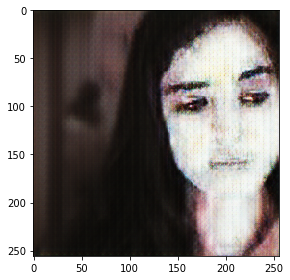

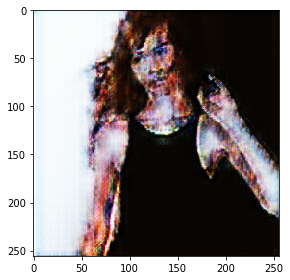

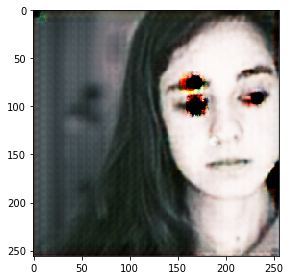

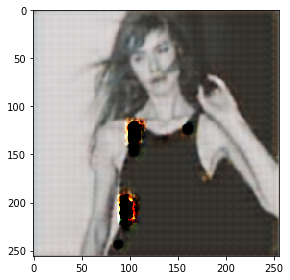

500: [d_target loss: 0.184276] [d_source loss: 0.154613] [adv loss: 11.412689] [time: 0:20:54.288396]
501: [d_target loss: 0.197810] [d_source loss: 0.193972] [adv loss: 15.337327] [time: 0:20:56.754087]
502: [d_target loss: 0.217774] [d_source loss: 0.172643] [adv loss: 7.207611] [time: 0:20:59.225486]
503: [d_target loss: 0.224120] [d_source loss: 0.257011] [adv loss: 11.458798] [time: 0:21:01.683434]
504: [d_target loss: 0.205587] [d_source loss: 0.127127] [adv loss: 10.967026] [time: 0:21:04.129579]
505: [d_target loss: 0.184629] [d_source loss: 0.105027] [adv loss: 11.798109] [time: 0:21:06.583735]
506: [d_target loss: 0.230961] [d_source loss: 0.158364] [adv loss: 11.452772] [time: 0:21:09.043929]
507: [d_target loss: 0.195305] [d_source loss: 0.158022] [adv loss: 12.162560] [time: 0:21:11.492937]
508: [d_target loss: 0.207074] [d_source loss: 0.157519] [adv loss: 13.023537] [time: 0:21:13.952774]
509: [d_target loss: 0.197749] [d_source loss: 0.112896] [adv loss: 10.806727] [tim

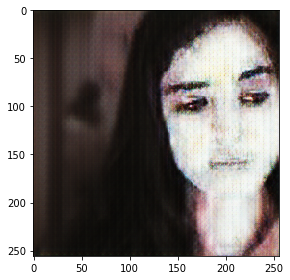

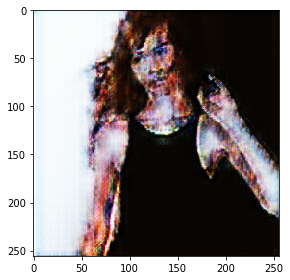

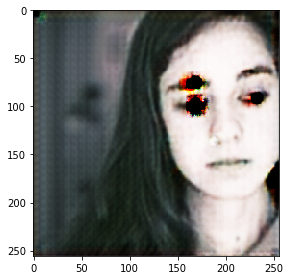

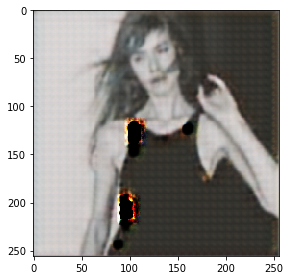

1000: [d_target loss: 0.109381] [d_source loss: 0.122724] [adv loss: 1.343311] [time: 0:41:24.152648]
1001: [d_target loss: 0.123515] [d_source loss: 0.146379] [adv loss: 1.104755] [time: 0:41:26.602346]
1002: [d_target loss: 0.142467] [d_source loss: 0.199756] [adv loss: 1.390941] [time: 0:41:29.058493]
1003: [d_target loss: 0.156250] [d_source loss: 0.246931] [adv loss: 1.196757] [time: 0:41:31.528591]
1004: [d_target loss: 0.159901] [d_source loss: 0.137410] [adv loss: 1.117156] [time: 0:41:33.989973]
1005: [d_target loss: 0.154172] [d_source loss: 0.153120] [adv loss: 1.304273] [time: 0:41:36.458543]
1006: [d_target loss: 0.167069] [d_source loss: 0.196361] [adv loss: 1.369794] [time: 0:41:38.903183]
1007: [d_target loss: 0.103084] [d_source loss: 0.148841] [adv loss: 1.300381] [time: 0:41:41.360574]
1008: [d_target loss: 0.132416] [d_source loss: 0.111668] [adv loss: 1.222327] [time: 0:41:43.824790]
1009: [d_target loss: 0.116073] [d_source loss: 0.101016] [adv loss: 1.105330] [ti

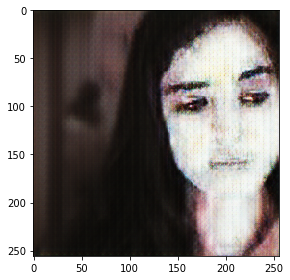

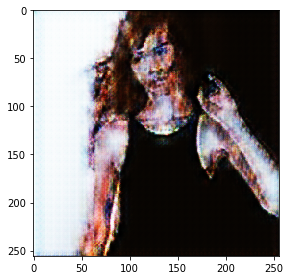

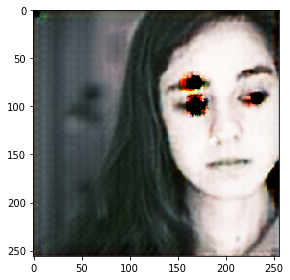

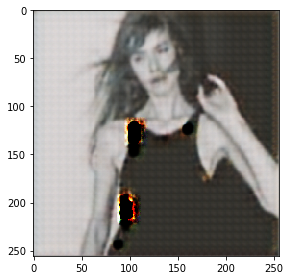

1500: [d_target loss: 0.122703] [d_source loss: 0.222598] [adv loss: 1.170031] [time: 1:01:53.043384]
1501: [d_target loss: 0.139111] [d_source loss: 0.146023] [adv loss: 1.092831] [time: 1:01:55.488067]
1502: [d_target loss: 0.104708] [d_source loss: 0.145881] [adv loss: 1.110049] [time: 1:01:57.944698]
1503: [d_target loss: 0.105275] [d_source loss: 0.159720] [adv loss: 1.085119] [time: 1:02:00.383924]
1504: [d_target loss: 0.084652] [d_source loss: 0.091271] [adv loss: 1.230715] [time: 1:02:02.841236]
1505: [d_target loss: 0.067439] [d_source loss: 0.090472] [adv loss: 1.080956] [time: 1:02:05.561098]
1506: [d_target loss: 0.088347] [d_source loss: 0.135229] [adv loss: 0.961211] [time: 1:02:08.013252]
1507: [d_target loss: 0.076761] [d_source loss: 0.118313] [adv loss: 1.125374] [time: 1:02:10.458990]
1508: [d_target loss: 0.074758] [d_source loss: 0.092023] [adv loss: 1.084276] [time: 1:02:12.916569]
1509: [d_target loss: 0.098697] [d_source loss: 0.140510] [adv loss: 1.104130] [ti

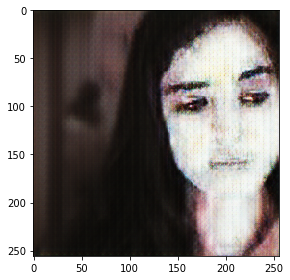

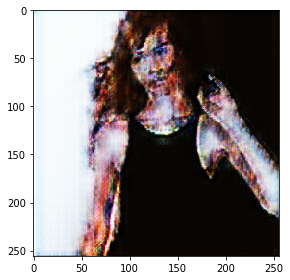

2000: [d_target loss: 0.065185] [d_source loss: 0.118833] [adv loss: 1.345702] [time: 1:22:21.701241]
2001: [d_target loss: 0.087971] [d_source loss: 0.144503] [adv loss: 1.019929] [time: 1:22:24.150573]
2002: [d_target loss: 0.064895] [d_source loss: 0.110860] [adv loss: 0.965441] [time: 1:22:26.608356]
2003: [d_target loss: 0.092600] [d_source loss: 0.158411] [adv loss: 1.144873] [time: 1:22:29.053771]
2004: [d_target loss: 0.087197] [d_source loss: 0.116101] [adv loss: 0.995245] [time: 1:22:31.499306]
2005: [d_target loss: 0.099259] [d_source loss: 0.137470] [adv loss: 1.176002] [time: 1:22:33.952716]
2006: [d_target loss: 0.141174] [d_source loss: 0.129621] [adv loss: 0.786037] [time: 1:22:36.405087]
2007: [d_target loss: 0.104943] [d_source loss: 0.171006] [adv loss: 0.972555] [time: 1:22:38.861807]
2008: [d_target loss: 0.110190] [d_source loss: 0.180856] [adv loss: 0.967045] [time: 1:22:41.306067]
2009: [d_target loss: 0.104059] [d_source loss: 0.138785] [adv loss: 0.982153] [ti

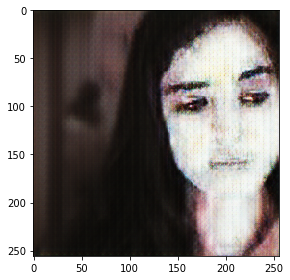

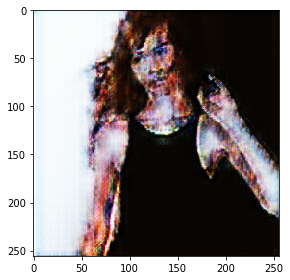

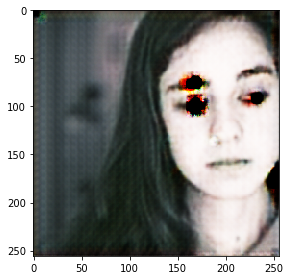

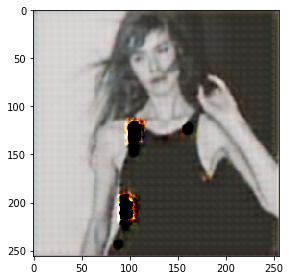

2500: [d_target loss: 0.084996] [d_source loss: 0.150906] [adv loss: 1.099305] [time: 1:42:49.714539]
2501: [d_target loss: 0.067540] [d_source loss: 0.094000] [adv loss: 1.064432] [time: 1:42:52.156825]
2502: [d_target loss: 0.087108] [d_source loss: 0.113405] [adv loss: 0.959668] [time: 1:42:54.618837]
2503: [d_target loss: 0.076381] [d_source loss: 0.118720] [adv loss: 0.999253] [time: 1:42:57.093173]
2504: [d_target loss: 0.071357] [d_source loss: 0.103583] [adv loss: 0.822121] [time: 1:42:59.555236]
2505: [d_target loss: 0.102003] [d_source loss: 0.149520] [adv loss: 0.914344] [time: 1:43:01.992682]
2506: [d_target loss: 0.089775] [d_source loss: 0.137302] [adv loss: 0.947984] [time: 1:43:04.444852]
2507: [d_target loss: 0.060051] [d_source loss: 0.147310] [adv loss: 1.299716] [time: 1:43:06.886349]
2508: [d_target loss: 0.095200] [d_source loss: 0.143034] [adv loss: 1.212079] [time: 1:43:09.331562]
2509: [d_target loss: 0.055380] [d_source loss: 0.127471] [adv loss: 0.929070] [ti

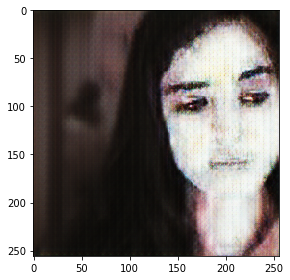

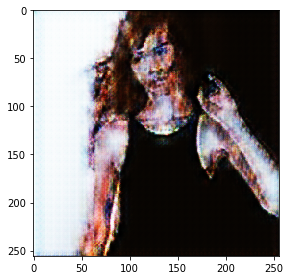

3000: [d_target loss: 0.081496] [d_source loss: 0.177661] [adv loss: 1.022977] [time: 2:03:16.051523]
3001: [d_target loss: 0.075497] [d_source loss: 0.125758] [adv loss: 0.981480] [time: 2:03:18.492008]
3002: [d_target loss: 0.072342] [d_source loss: 0.121468] [adv loss: 1.052485] [time: 2:03:20.944849]
3003: [d_target loss: 0.050785] [d_source loss: 0.101976] [adv loss: 1.014036] [time: 2:03:23.384811]
3004: [d_target loss: 0.091912] [d_source loss: 0.192256] [adv loss: 0.994160] [time: 2:03:25.839140]
3005: [d_target loss: 0.080090] [d_source loss: 0.135943] [adv loss: 0.945790] [time: 2:03:28.280813]
3006: [d_target loss: 0.066464] [d_source loss: 0.105349] [adv loss: 0.963363] [time: 2:03:30.723645]
3007: [d_target loss: 0.071814] [d_source loss: 0.063890] [adv loss: 1.015171] [time: 2:03:33.168686]
3008: [d_target loss: 0.070044] [d_source loss: 0.129123] [adv loss: 1.172687] [time: 2:03:35.626976]
3009: [d_target loss: 0.153024] [d_source loss: 0.104352] [adv loss: 1.100087] [ti

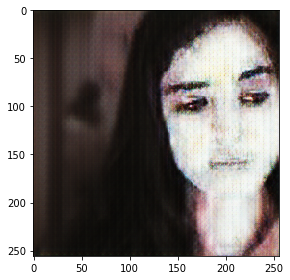

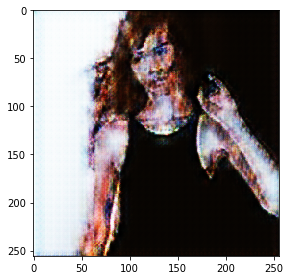

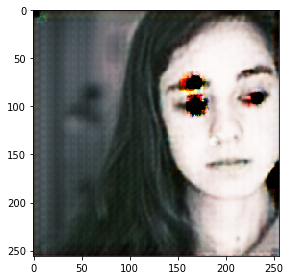

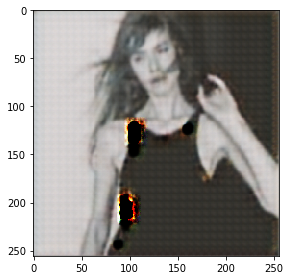

3500: [d_target loss: 0.048082] [d_source loss: 0.109796] [adv loss: 0.996774] [time: 2:23:43.472323]
3501: [d_target loss: 0.059365] [d_source loss: 0.100363] [adv loss: 0.857808] [time: 2:23:45.900709]
3502: [d_target loss: 0.093331] [d_source loss: 0.206690] [adv loss: 1.034437] [time: 2:23:48.342623]
3503: [d_target loss: 0.072317] [d_source loss: 0.097474] [adv loss: 0.930247] [time: 2:23:50.783365]
3504: [d_target loss: 0.053719] [d_source loss: 0.143101] [adv loss: 1.485037] [time: 2:23:53.229920]
3505: [d_target loss: 0.057260] [d_source loss: 0.103747] [adv loss: 1.090932] [time: 2:23:55.682915]
3506: [d_target loss: 0.045909] [d_source loss: 0.142050] [adv loss: 0.967587] [time: 2:23:58.127040]
3507: [d_target loss: 0.063823] [d_source loss: 0.105014] [adv loss: 0.805479] [time: 2:24:00.578007]
3508: [d_target loss: 0.105599] [d_source loss: 0.188340] [adv loss: 0.764696] [time: 2:24:03.011287]
3509: [d_target loss: 0.057411] [d_source loss: 0.128500] [adv loss: 0.767604] [ti

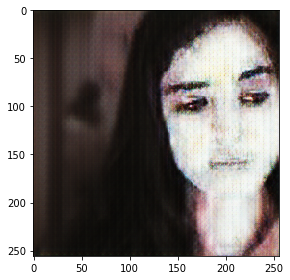

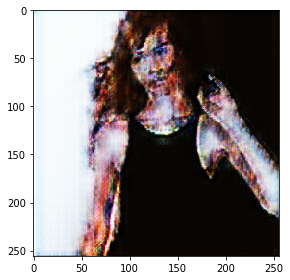

4000: [d_target loss: 0.047640] [d_source loss: 0.096844] [adv loss: 1.025246] [time: 2:44:09.376518]
4001: [d_target loss: 0.050411] [d_source loss: 0.129429] [adv loss: 0.954502] [time: 2:44:11.816054]
4002: [d_target loss: 0.038326] [d_source loss: 0.114085] [adv loss: 0.983992] [time: 2:44:14.274692]
4003: [d_target loss: 0.057542] [d_source loss: 0.120466] [adv loss: 0.876139] [time: 2:44:16.705653]
4004: [d_target loss: 0.099187] [d_source loss: 0.103972] [adv loss: 0.720158] [time: 2:44:19.144359]
4005: [d_target loss: 0.087603] [d_source loss: 0.105209] [adv loss: 0.758762] [time: 2:44:21.585531]
4006: [d_target loss: 0.131505] [d_source loss: 0.130182] [adv loss: 0.731095] [time: 2:44:24.015604]
4007: [d_target loss: 0.102759] [d_source loss: 0.141377] [adv loss: 0.867684] [time: 2:44:26.449410]
4008: [d_target loss: 0.056826] [d_source loss: 0.087484] [adv loss: 0.785381] [time: 2:44:28.888750]
4009: [d_target loss: 0.078880] [d_source loss: 0.121241] [adv loss: 0.987390] [ti

In [ ]:
import math
graycifar10_cross_colorcifar10(resume=1)